In [1]:
import turicreate as tc

In [2]:
from __future__ import division
import numpy as np

In [3]:
products = tc.SFrame('amazon_baby')

In [6]:
def remove_punctuation(text):
    import string
    return text.translate( string.punctuation) 

# Remove punctuation.
review_clean = products['review'].apply(remove_punctuation)

# Count words
products['word_count'] = tc.text_analytics.count_words(review_clean)

# Drop neutral sentiment reviews.
products = products[products['rating'] != 3]

# Positive sentiment to +1 and negative sentiment to -1
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [7]:
products

name,review,rating,word_count,sentiment
Planetwise Wipe Pouch,it came early and was notdisappointed. i love ...,5.0,"{'recommend': 1.0,'highly': 1.0, ...",1
Annas Dream Full Quiltwith 2 Shams ...,Very soft and comfortableand warmer than it ...,5.0,"{'quilt': 1.0, 'of': 1.0,'the': 1.0, 'than': 1.0, ...",1
Stop Pacifier Suckingwithout tears with ...,This is a product wellworth the purchase. I ...,5.0,"{'tool': 1.0, 'clever':1.0, 'approach': 2.0, ...",1
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,"{'rock': 1.0, 'many':1.0, 'headaches': 1.0, ...",1
Stop Pacifier Suckingwithout tears with ...,"When the Binky Fairy cameto our house, we didn't ...",5.0,"{'thumb': 1.0, 'or': 1.0,'break': 1.0, 'trying': ...",1
A Tale of Baby's Dayswith Peter Rabbit ...,"Lovely book, it's boundtightly so you may no ...",4.0,"{'for': 1.0, 'barnes':1.0, 'at': 1.0, 'is': ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",Perfect for new parents.We were able to keep ...,5.0,"{'right': 1.0, 'because':1.0, 'questions': 1.0, ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",A friend of mine pinnedthis product on Pinte ...,5.0,"{'like': 1.0, 'and': 1.0,'changes': 1.0, 'the': ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",This has been an easy wayfor my nanny to record ...,4.0,"{'in': 1.0, 'pages': 1.0,'out': 1.0, 'run': 1.0, ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",I love this journal andour nanny uses it ...,4.0,"{'tracker': 1.0, 'now':1.0, 'its': 1.0, 'sti ...",1


In [8]:
train_data, test_data = products.random_split(.8, seed=1)

In [9]:
model = tc.logistic_classifier.create(train_data, target='sentiment',
                                            features=['word_count'],
                                            validation_set=None)

Logistic regression:

--------------------------------------------------------

Number of examples          : 133416

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 57445

Number of coefficients      : 57446

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 4        | 0.250000  | 3.503960     | 0.840724          |

| 1         | 9        | 3.250000  | 5.500527     | 0.931642          |

| 2         | 11       | 2.656037  | 6.424612     | 0.938621          |

| 3         | 12       | 2.656037  | 7.127378     | 0.927535          |

| 4         | 14       | 1.341935  | 7.975400     | 0.945441          |

| 9         | 20       | 1.341935  | 11.653385    | 0.977387          |

+-----------+----------+-----------+--------------+-------------------+

In [10]:
accuracy= model.evaluate(test_data, metric='accuracy')['accuracy']
print ("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.9178365730741541


In [11]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print ("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


In [12]:
confusion_matrix = model.evaluate(test_data, metric='confusion_matrix')['confusion_matrix']
confusion_matrix

target_label,predicted_label,count
1,-1,1369
-1,-1,3871
-1,1,1370
1,1,26726


In [13]:
false_positive = confusion_matrix['count'][(confusion_matrix['target_label'] == -1) & (confusion_matrix['predicted_label'] == +1)]
false_positive

dtype: int
Rows: ?
[1370, ... ]

In [14]:
false_positive_test = confusion_matrix[(confusion_matrix['target_label'] == -1) & (confusion_matrix['predicted_label'] == +1)]['count'][0]
false_negative_test = confusion_matrix[(confusion_matrix['target_label'] == +1) & (confusion_matrix['predicted_label'] == -1)]['count'][0]

In [16]:
cost_test = (100 * false_positive_test) + (1 * false_negative_test)
cost_test

138369

In [17]:
precision = model.evaluate(test_data, metric='precision')['precision']
print( "Precision on test data: %s" % precision)

Precision on test data: 0.9512386104783599


In [18]:
false_positive/confusion_matrix['count'].sum()

dtype: float
Rows: ?
[0.04109671226301896, ... ]

In [19]:
recall = model.evaluate(test_data, metric='recall')['recall']
print ("Recall on test data: %s" % recall)

Recall on test data: 0.9512724684107492


In [21]:
def apply_threshold(probabilities, threshold):
    ### YOUR CODE GOES HERE
    # +1 if >= threshold and -1 otherwise.
    ans = tc.SArray([+1 if x >= threshold else -1 for x in probabilities])
    return ans

In [22]:

probabilities = model.predict(test_data, output_type='probability')
predictions_with_default_threshold = apply_threshold(probabilities, 0.5)
predictions_with_high_threshold = apply_threshold(probabilities, 0.9)

In [23]:
print ("Number of positive predicted reviews (threshold = 0.5): %s" % (predictions_with_default_threshold == 1).sum())

Number of positive predicted reviews (threshold = 0.5): 28096


In [24]:
print ("Number of positive predicted reviews (threshold = 0.9): %s" % (predictions_with_high_threshold == 1).sum())

Number of positive predicted reviews (threshold = 0.9): 25664


In [26]:
# Threshold = 0.5
precision_with_default_threshold = tc.evaluation.precision(test_data['sentiment'],
                                        predictions_with_default_threshold)

recall_with_default_threshold = tc.evaluation.recall(test_data['sentiment'],
                                        predictions_with_default_threshold)

# Threshold = 0.9
precision_with_high_threshold = tc.evaluation.precision(test_data['sentiment'],
                                        predictions_with_high_threshold)
recall_with_high_threshold = tc.evaluation.recall(test_data['sentiment'],
                                        predictions_with_high_threshold)

In [27]:
print ("Precision (threshold = 0.5): %s" % precision_with_default_threshold)
print ("Recall (threshold = 0.5)   : %s" % recall_with_default_threshold)
print ("Precision (threshold = 0.9): %s" % precision_with_high_threshold)
print ("Recall (threshold = 0.9)   : %s" % recall_with_high_threshold)

Precision (threshold = 0.5): 0.9512386104783599
Recall (threshold = 0.5)   : 0.9512724684107492
Precision (threshold = 0.9): 0.9706203241895262
Recall (threshold = 0.9)   : 0.8866346324968856


In [28]:
threshold_values = np.linspace(0.5, 1, num=100)
threshold_values

array([0.5       , 0.50505051, 0.51010101, 0.51515152, 0.52020202,
       0.52525253, 0.53030303, 0.53535354, 0.54040404, 0.54545455,
       0.55050505, 0.55555556, 0.56060606, 0.56565657, 0.57070707,
       0.57575758, 0.58080808, 0.58585859, 0.59090909, 0.5959596 ,
       0.6010101 , 0.60606061, 0.61111111, 0.61616162, 0.62121212,
       0.62626263, 0.63131313, 0.63636364, 0.64141414, 0.64646465,
       0.65151515, 0.65656566, 0.66161616, 0.66666667, 0.67171717,
       0.67676768, 0.68181818, 0.68686869, 0.69191919, 0.6969697 ,
       0.7020202 , 0.70707071, 0.71212121, 0.71717172, 0.72222222,
       0.72727273, 0.73232323, 0.73737374, 0.74242424, 0.74747475,
       0.75252525, 0.75757576, 0.76262626, 0.76767677, 0.77272727,
       0.77777778, 0.78282828, 0.78787879, 0.79292929, 0.7979798 ,
       0.8030303 , 0.80808081, 0.81313131, 0.81818182, 0.82323232,
       0.82828283, 0.83333333, 0.83838384, 0.84343434, 0.84848485,
       0.85353535, 0.85858586, 0.86363636, 0.86868687, 0.87373

In [29]:
precision_all = []
recall_all = []

probabilities = model.predict(test_data, output_type='probability')
for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    
    precision = tc.evaluation.precision(test_data['sentiment'], predictions)
    recall = tc.evaluation.recall(test_data['sentiment'], predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

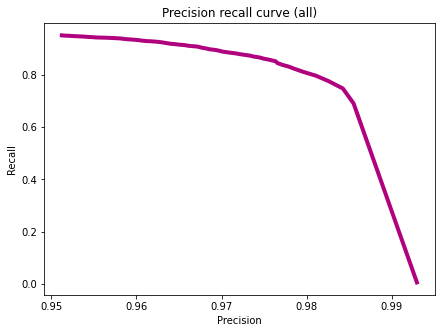

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})
    
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

In [31]:
threshold_values[np.array(precision_all) >= 0.965].min()

0.803030303030303

In [33]:
threshold = 0.98
predictions = apply_threshold(probabilities, threshold)
confusion_matrix = tc.evaluation.confusion_matrix(test_data['sentiment'], predictions)
confusion_matrix

target_label,predicted_label,count
1,-1,5740
1,1,22355
-1,1,429
-1,-1,4812


In [34]:
confusion_matrix[(confusion_matrix['target_label'] == +1) & (confusion_matrix['predicted_label'] == -1)]['count'][0]

5740

In [35]:
baby_reviews =  test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]

In [36]:

probabilities = model.predict(baby_reviews, output_type='probability')

In [37]:
threshold_values = np.linspace(0.5, 1, num=100)

In [38]:
precision_all = []
recall_all = []

for threshold in threshold_values:
    
    # Make predictions. Use the `apply_threshold` function 
    ## YOUR CODE HERE 
    predictions = apply_threshold(probabilities, threshold)
    
    # Calculate the precision.
    # YOUR CODE HERE
    precision = tc.evaluation.precision(baby_reviews['sentiment'], predictions)
    
    # YOUR CODE HERE
    recall = tc.evaluation.recall(baby_reviews['sentiment'], predictions)
    
    # Append the precision and recall scores.
    precision_all.append(precision)
    recall_all.append(recall)

In [39]:
threshold_values[np.array(precision_all) >= 0.965].min()

0.8383838383838385

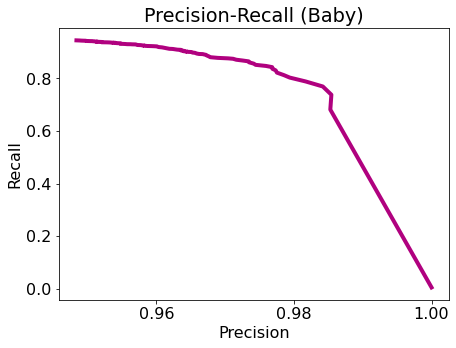

In [40]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")